In [1]:
#importing some useful packages
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

#class for detecting line lanes        
class line_detector:    
    def __init__(self):
        #camera calibration parameters
        self.mtx = []
        self.dist = []
        #warp matrix
        self.M = []
        #stats
        self.thresholded_m = []
        self.thresholded_w = 0.9
        self.thresholded_t = 1.0
        self.img_cnt = 0
        self.left_fit = []
        self.right_fit = []
        
    def reset_m(self):
        self.img_cnt = 0
        self.thresholded_m = []
        self.left_fit = []
        self.right_fit = []
    
    def grayscale(self, image):
        return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    def calibrate_camera(self, images_list, size):
        objpoints = []
        imgpoints = []
        objp = np.zeros((size[1]*size[0],3), np.float32)
        objp[:,:2] = np.mgrid[0:size[0], 0:size[1]].T.reshape(-1,2)
        for fname in images:
            img = mpimg.imread(fname)
            gray = self.grayscale(img)
            ret, corners = cv2.findChessboardCorners(gray, (size[0],size[1]), None)
            if ret == True:
                imgpoints.append(corners)
                objpoints.append(objp)      
                
        ret, self.mtx, self.dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
        return ret
    
    def undistort(self, image):
        return cv2.undistort(image, self.mtx, self.dist, None, self.mtx)
        
    def calibrate_perspective(self, image, size, offset):
        gray = self.grayscale(image)
        ret, corners = cv2.findChessboardCorners(gray, (size[0],size[1]), None)
    
        if ret == True:
            #cv2.drawChessboardCorners(dest, (size[0],size[1]), corners, ret)       
            src = np.float32([corners[0], corners[size[0]-1], corners[-1], corners[-size[0]]])
            dst = np.float32([[offset, offset], [image.shape[1]-offset, offset], [image.shape[1]-offset, image.shape[0]-offset], [offset, image.shape[0]-offset]])

            self.M = cv2.getPerspectiveTransform(src, dst)
        
    def get_warp(self, image, offset):
        src = self.vertices.astype(np.float32)
        #np.float32([self.vertices[0], self.vertices[1], self.vertices[2], self.vertices[3]]) 
        ox = offset[0]
        oy = offset[1]
        dst = np.float32([[ox, oy], [image.shape[1]-ox, oy], [image.shape[1]-ox, image.shape[0]-oy], [ox, image.shape[0]-oy]])
        #dst = np.float32([[300, 720], [300, 0], [980, 0], [980, 720]])
        self.M = cv2.getPerspectiveTransform(src, dst)
        
    def warp_image(self, image):
        #gray = self.grayscale(image)
        #return cv2.warpPerspective(gray, self.M, gray.shape[::-1])
        return cv2.warpPerspective(image, self.M, (image.shape[1], image.shape[0]))
    
    def unwarp_image(self, image):
        #gray = self.grayscale(image)
        #return cv2.warpPerspective(gray, self.M, gray.shape[::-1])
        return cv2.warpPerspective(image, np.linalg.inv(self.M), (image.shape[1], image.shape[0]))
    
    
    def dir_threshold(self, img, sobel_kernel=3, thresh=(0.7, 1.3)):
        # Calculate the x and y gradients
        sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        # Take the absolute value of the gradient direction, 
        # apply a threshold, and create a binary image result
        absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
        binary =  np.zeros_like(absgraddir)
        binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
        return binary
    
    def mag_thresh(self, img, sobel_kernel=3, mag_thresh=(30, 100)):
        #Take the derivative in x or y given orient = 'x' or 'y'
        sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
        sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize = sobel_kernel)    
        sobel = np.sqrt(sobelx**2+sobely**2)
        scaling = np.max(sobel)/255
        sobel = np.uint8(sobel/scaling)
        binary = np.zeros_like(sobel)
        binary[(sobel >= mag_thresh[0]) & (sobel <= mag_thresh[1])] = 1
        return binary
    
    def abs_thresh(self, img, sobel_kernel=3, abs_thresh=(30,100)):
        sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize = sobel_kernel) # Take the derivative in x
        abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))    
        # Threshold x gradient
        binary = np.zeros_like(scaled_sobel)
        binary[(scaled_sobel >= abs_thresh[0]) & (scaled_sobel <= abs_thresh[1])] = 1 
        return binary
    
    def color_thresh(self, img, thresh=(170, 255)):
        binary = np.zeros_like(img)
        binary[(img >= thresh[0]) & (img <= thresh[1])] = 1        
        return binary
    
    def threshold_image(self, image):
        # Convert to HLS color space and separate the V channel
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS).astype(np.float)
        l_channel = hls[:,:,1]
        s_channel = hls[:,:,2]
        # Sobel x
        gradx = self.abs_thresh(l_channel, 3, (30,100))        
        # Magnitude
        mag = self.mag_thresh(gray, 3, (30,100))
        # Threshold color channel
        color = self.color_thresh(s_channel, (100,255))
        # Directional
        direct = self.dir_threshold(s_channel, 3, (0.7, 1.3))
        # Combine the two binary thresholds
        combined_binary = np.zeros_like(gray)
        combined_binary[(((gradx == 1) | (color == 1) | (mag == 1)) & (direct == 1))] = 1
        
        if len(self.thresholded_m)==0:
            self.thresholded_m = combined_binary.astype(np.float32)
        else:
            self.thresholded_m = self.thresholded_m*self.thresholded_w
            self.thresholded_m[(combined_binary==1)] = 1.
            
        result = np.zeros_like(combined_binary)
        result[(self.thresholded_m >= self.thresholded_t)] = 1
        # Stack each channel
        #return combined_binary          

        return result
                  
    def find_lane_lines(self, warped, nwindows = 9, margin = 100, minpix = 50):
        #nwindows: number of sliding windows
        #margin: margin from the left and right side of the thresholded image
        #minpix: minimum number of pixels found to recenter window
        
        if len(self.left_fit):
            return self.findnext(warped, margin)
        
        histogram = np.sum(warped[int(warped.shape[0]/2):,:], axis=0)
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((warped, warped, warped))*255
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
        # Set height of windows
        window_height = np.int(warped.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = warped.shape[0] - (window+1)*window_height
            win_y_high = warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 2) 
            #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        self.left_fit = np.polyfit(lefty, leftx, 2)
        self.right_fit = np.polyfit(righty, rightx, 2)
        
        return (self.left_fit, self.right_fit)
    
    def findnext(self, warped, margin = 100):
        # Assume you now have a new warped binary image 
        # from the next frame of video (also called "binary_warped")
        # It's now much easier to find line pixels!
        nonzero = warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        left_lane_inds = ((nonzerox > (self.left_fit[0]*(nonzeroy**2) + self.left_fit[1]*nonzeroy + 
        self.left_fit[2] - margin)) & (nonzerox < (self.left_fit[0]*(nonzeroy**2) + 
        self.left_fit[1]*nonzeroy + self.left_fit[2] + margin))) 

        right_lane_inds = ((nonzerox > (self.right_fit[0]*(nonzeroy**2) + self.right_fit[1]*nonzeroy + 
        self.right_fit[2] - margin)) & (nonzerox < (self.right_fit[0]*(nonzeroy**2) + 
        self.right_fit[1]*nonzeroy + self.right_fit[2] + margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        # Fit a second order polynomial to each
        self.left_fit = np.polyfit(lefty, leftx, 2)
        self.right_fit = np.polyfit(righty, rightx, 2)
        # Generate x and y values for plotting
        #ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        #left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        #right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        return (self.left_fit, self.right_fit)

    def plot_lanes(self, thresholded, plot):
        # Generate x and y values for plotting
        ploty = np.linspace(0, thresholded.shape[0]-1, thresholded.shape[0] )
        left_fitx = self.left_fit[0]*ploty**2 + self.left_fit[1]*ploty + self.left_fit[2]
        right_fitx = self.right_fit[0]*ploty**2 + self.right_fit[1]*ploty + self.right_fit[2]
        #out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        #out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plot.imshow(thresholded, cmap="gray")
        plot.plot(left_fitx, ploty, color='green')
        plot.plot(right_fitx, ploty, color='green')
        #plot.xlim(0, 1280)
        #plot.ylim(720, 0)
        
    def get_results(self, thresholded):
        ploty = np.linspace(0, thresholded.shape[0]-1, thresholded.shape[0] )
        left_fitx = self.left_fit[0]*ploty**2 + self.left_fit[1]*ploty + self.left_fit[2]
        right_fitx = self.right_fit[0]*ploty**2 + self.right_fit[1]*ploty + self.right_fit[2]
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*thresholded.shape[0]*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*thresholded.shape[0]*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
        radius = (left_curverad+right_curverad)/2
        center = thresholded.shape[1]/2
        pl = left_fitx[thresholded.shape[0]-1]
        pr = right_fitx[thresholded.shape[0]-1]
        #Position is a distance from the middle of the lane - positive values mean the car is to the right
        position = xm_per_pix*((pl+pr)/2-center)
        
        area = np.zeros_like(thresholded)
        for y in range(thresholded.shape[0]):
            for x in range(int(left_fitx[y]), int(right_fitx[y])):
                if x==thresholded.shape[1]:
                    break
                area[y][x] = 1
                
        return (radius, position, area)

    def region_of_interest(self, img):
        #defining a blank mask to start with
        mask = np.zeros_like(img)   
    
        #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
        if len(img.shape) > 2:
            channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
            ignore_mask_color = (255,) * channel_count
        else:
            ignore_mask_color = 255
        
        #filling pixels inside the polygon defined by "vertices" with the fill color    
        cv2.fillPoly(mask, self.vertices, ignore_mask_color)
    
        #returning the image only where mask pixels are nonzero
        masked_image = cv2.bitwise_and(img, mask)
        return masked_image

    def weighted_img(self, img, initial_img, α=0.8, β=1., λ=0.):
        return cv2.addWeighted(initial_img, α, img, β, λ)
    
    def set_roi(self, p1, p2, p3, p4):
        self.vertices = np.array([[p1, p2, p3, p4]], dtype=np.int32)
    
    def process_image(self, image):
        undistorted = self.undistort(image)
        thresholded = self.threshold_image(undistorted)
        warped = self.warp_image(thresholded)
        (left_fit, right_fit) = self.find_lane_lines(warped)
        (radius, position, lane) = self.get_results(warped)
        
        """
        fname = "warped{}.jpg".format(self.img_cnt)
        self.img_cnt = self.img_cnt+1
        mpimg.imsave(fname, warped)
        """
                
        #warping back
        area = np.zeros_like(image)
        area[:,:,1] = self.unwarp_image(lane)*255

        result = self.weighted_img(area, image, α=0.8, β=0.4, λ=0.)
        tmp = ""
        if position<0:
            tmp = "to the left"
        else:
            tmp = "to the right"
        font = cv2.FONT_HERSHEY_COMPLEX_SMALL
        cv2.putText(result,'Radius:  {}m'.format(int(radius)),(30,50), font, 2,(255,255,255),2,cv2.LINE_AA)
        cv2.putText(result,'Position: {:4.2f}m {}'.format(np.abs(position), tmp),(30,90), font, 2,(255,255,255),2,cv2.LINE_AA)       
        
        return result


In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

images = glob.glob("camera_cal/calibration*.jpg")
cal_img = mpimg.imread("camera_cal/calibration2.jpg")
test_img = mpimg.imread("test_images/straight_lines1.jpg")

detector = line_detector()
detector.calibrate_camera(images, (9,6))

"""
dst = detector.undistort(test_img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
"""

"\ndst = detector.undistort(test_img)\n\nf, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))\nf.tight_layout()\nax1.imshow(test_img)\nax1.set_title('Original Image', fontsize=50)\nax2.imshow(dst)\nax2.set_title('Undistorted Image', fontsize=50)\nplt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)\n"

In [3]:
"""
detector.calibrate_perspective(cal_img, (9,6), 100)

undistorted = detector.undistort(cal_img)
warped = detector.warp_image(undistorted)

plt.imshow(warped)
"""

'\ndetector.calibrate_perspective(cal_img, (9,6), 100)\n\nundistorted = detector.undistort(cal_img)\nwarped = detector.warp_image(undistorted)\n\nplt.imshow(warped)\n'

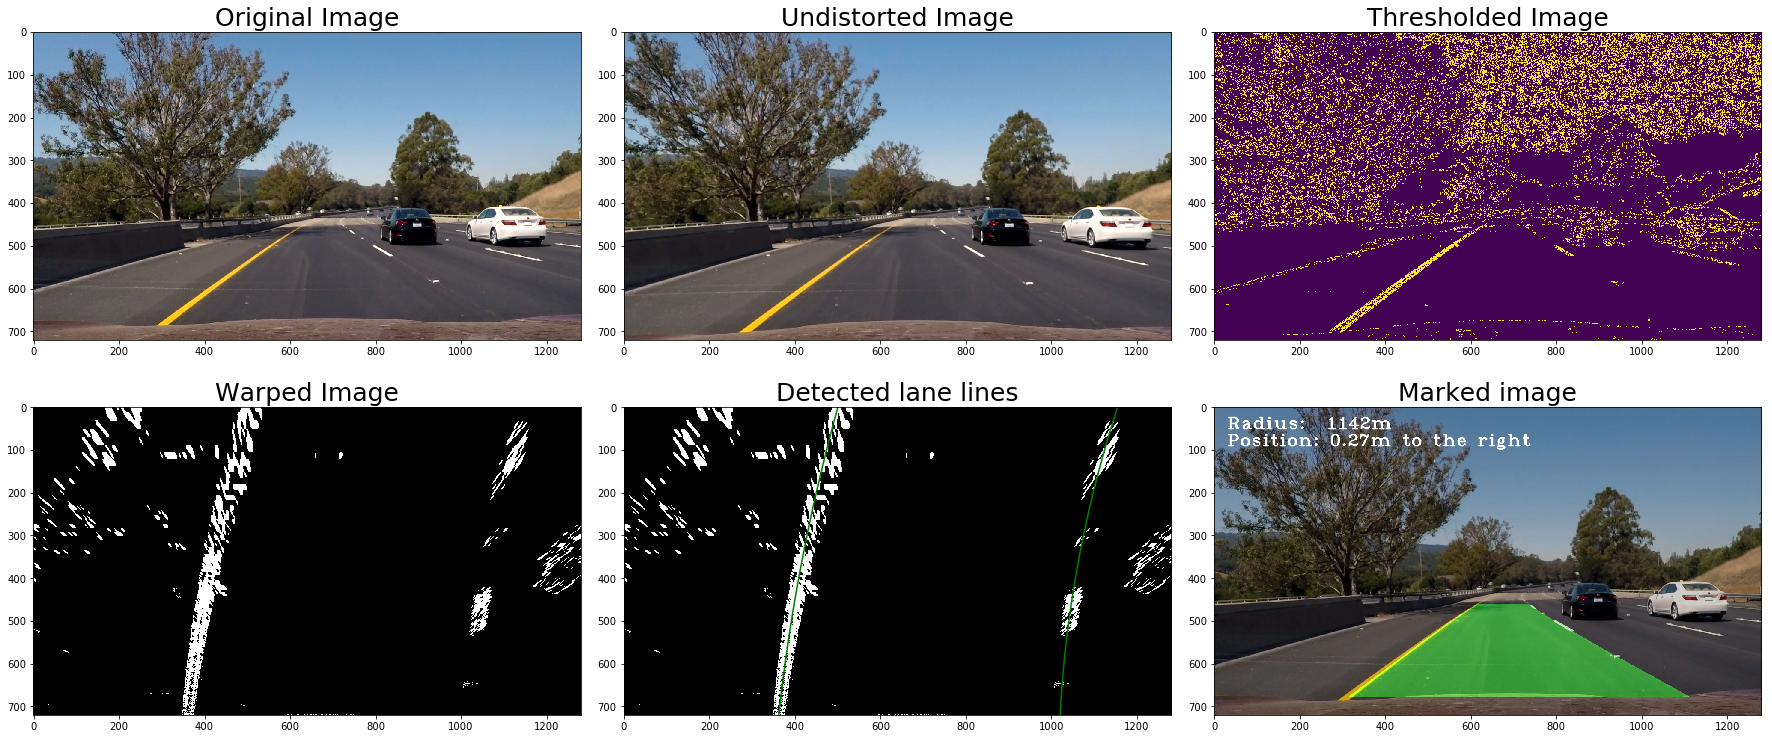

In [4]:
%matplotlib inline

test_img = mpimg.imread("test_images/test6.jpg")
#test_img = mpimg.imread("bscap/bscap0005.jpg")

#detector.set_roi((595,450), (689, 450), (1085, 700), (235, 700))
detector.reset_m()
#detector.set_roi((610,441), (666, 441), (1041, 678), (261, 678))
detector.set_roi((581,460), (700, 460), (1041, 678), (261, 678))
detector.get_warp(test_img, (320, 0))

undistorted = detector.undistort(test_img)
roi = detector.region_of_interest(undistorted)
#plt.imshow(roi)

thresholded = detector.threshold_image(undistorted)

#plt.imshow(thresholded)

warped = detector.warp_image(thresholded)
(left_fit, right_fit) = detector.find_lane_lines(warped)
(radius, position, lane) = detector.get_results(warped)
area = np.zeros_like(test_img)
area[:,:,1] = detector.unwarp_image(lane)*255

result = detector.weighted_img(area, test_img, α=0.8, β=0.4, λ=0.)
tmp = ""
if position<0:
    tmp = "to the left"
else:
    tmp = "to the right"
font = cv2.FONT_HERSHEY_COMPLEX_SMALL
cv2.putText(result,'Radius:  {}m'.format(int(radius)),(30,50), font, 2,(255,255,255),2,cv2.LINE_AA)
cv2.putText(result,'Position: {:4.2f}m {}'.format(np.abs(position), tmp),(30,90), font, 2,(255,255,255),2,cv2.LINE_AA)

f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=25)
ax3.imshow(thresholded)
ax3.set_title('Thresholded Image', fontsize=25)
ax4.imshow(warped, cmap="gray")
ax4.set_title('Warped Image', fontsize=25)
detector.plot_lanes(warped, ax5)
ax5.set_title('Detected lane lines', fontsize=25)
ax6.imshow(result)
ax6.set_title('Marked image', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=1.1, bottom=0.)

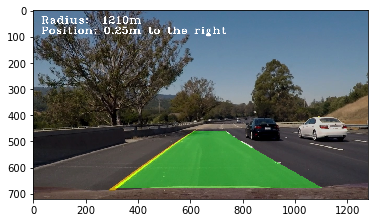

In [5]:
res = detector.process_image(test_img)
plt.imshow(res)

In [6]:
#input = "test_videos/solidWhiteRight.mp4"
#input = "test_videos/solidYellowLeft.mp4"
#input = "test_videos/challenge.mp4"
input = "project_video.mp4"
output = "output.mp4"
#input = "challenge_video.mp4"
#output = "output.mp4"

test_clip = VideoFileClip(input)
detector.reset_m()
#detector.set_roi((610,441), (666, 441), (1041, 678), (261, 678))
detector.set_roi((581,460), (700, 460), (1041, 678), (261, 678))
detector.get_warp(test_img, (320, 00))
    
new_clip = test_clip.fl_image( detector.process_image )
%time new_clip.write_videofile(output, audio=False)


[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [07:56<00:00,  2.61it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

Wall time: 7min 56s


In [7]:
HTML("""
<video width="640" height="300" controls>
  <source src={0} type="video/mp4">
</video>
""".format(output))